In [1]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn import datasets

## here are the user-defined functions and classes
from MarkovComputations import WeightMatrix, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error

In [27]:
def load_and_format_mnist(n_classes, scale):
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalize pixel values to range [0,1]
    x_train = scale * x_train.astype(np.float32) / 255.0
    x_test = scale * x_test.astype(np.float32) / 255.0

    # Combine train and test sets
    x_all = np.concatenate((x_train, x_test), axis=0)
    y_all = np.concatenate((y_train, y_test), axis=0)

    # Initialize an empty dictionary with keys for each digit class (0-9)
    mnist_dict = {i: [] for i in range(10)}

    # Populate the dictionary
    for img, label in zip(x_all, y_all):
        mnist_dict[label].append(np.array(img).flatten())

    ###  create InputData object
    if isinstance(n_classes, int):
        return InputData(n_classes, [mnist_dict[key] for key in range(n_classes)])
    else:
        return InputData(len(n_classes), [mnist_dict[key] for key in n_classes])


def load_and_format_iris(n_classes, scale):
    # Load the Iris dataset
    iris = datasets.load_iris()
    x_all, y_all = iris.data, iris.target  # Features and labels

    # Normalize features to range [0,1]
    x_all = scale * (x_all - x_all.min(axis=0)) / (x_all.max(axis=0) - x_all.min(axis=0))
    

    # Initialize a dictionary with keys for each class
    iris_dict = {i: [] for i in range(3)}

    # Populate the dictionary with feature vectors
    for features, label in zip(x_all, y_all):
        iris_dict[label].append(np.array(features).flatten())

    # Create and return InputData object
    return InputData(n_classes, [iris_dict[key] for key in range(n_classes)])



In [25]:
isinstance([3], int)

False

In [62]:
#########################################################
################  Parameter definitions #################
#########################################################

random.seed(20)

### Define parameters of classification
M = 2 # how many edges affected per input dimension
n_classes = 3 # D, how many classes
classes = [0,4,6]
input_dim = 28**2 # D, how many components of each input data
#input_dim = 4

### Define parameters of graph object and initial weights
n_nodes = 75 # assuming a complete graph
E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0

### Define parameters of trainig
n_training_iters = 1000 # how many training steps to take
eta = 1 # learning rate (increment of Ej, Bij, Fij)
delta_E = 1 # nuding factor (change in Ej at output nodes during nudging)

############################################################
################  Initialize weight_matrix #################
############################################################

## create graph
g = nx.complete_graph(n_nodes) # assuming a complete graph for now - easy to change
n_edges = len(list(g.edges())) 
print(M * input_dim / n_edges)


## get input and output inds
output_inds = get_output_inds(n_nodes, n_classes, False)
input_inds = get_input_inds(n_edges, input_dim, M)

## initialize first edge rates
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create WeightMatrix object
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)
weight_matrix.lower_output_energies(output_inds, 4) # lower energies at the output nodes to ease training


############################################################
################  Load classification data #################
############################################################

input_data = load_and_format_mnist(classes, 10)
# input_data = load_and_format_iris(n_classes, 10)



0.565045045045045


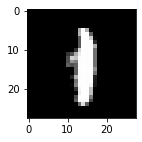

In [63]:
# Create a figure
plt.figure(figsize=(10, 2))

data = np.reshape(next(input_data.training_data[1]),(28,28))
#print(data)
plt.imshow(data, cmap='gray')  # Show in grayscale


plt.show()

In [ ]:
################################################
################  Run training #################
################################################

weight_matrix_orig = copy.deepcopy(weight_matrix) # save original rate matrix 

error_list = [] # track errors during training

for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes) # draw a random class label to present
    # inputs = next(input_data.training_data[class_number]) # get the next data point from the iterator for this class

    try:
        inputs = next(input_data.training_data[class_number])
    except StopIteration:
        input_data.refill_iterators()  # Refill iterators if exhausted
        inputs = next(input_data.training_data[class_number])  # Try again


    ss = weight_matrix.compute_ss_on_inputs(input_inds, inputs) # apply the data as input and get the steady state
    error_list.append(np.linalg.norm(compute_error(ss, input_data, class_number, output_inds))) # save error of this iteration
    nudged_ss = weight_matrix.compute_nudged_ss(input_data, class_number, input_inds, inputs, output_inds, delta_E) # get the steady state after applying a nudge on this input
    ss_frac = nudged_ss / ss # compute pi_nudge / pi
    
    weight_matrix.update(input_inds, inputs, ss_frac, eta) # update the weight_matrix
    

   
    

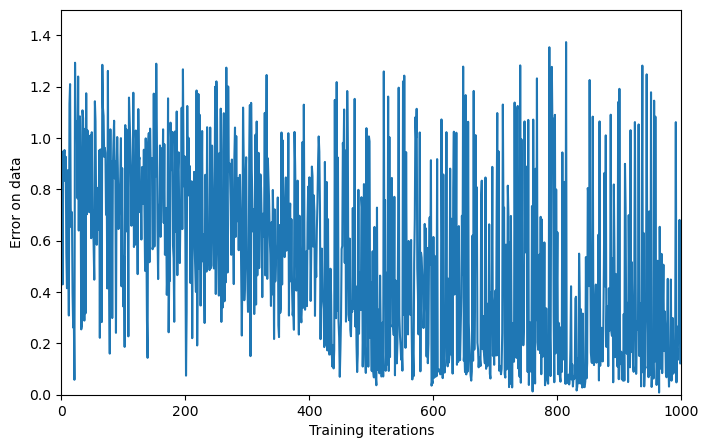

In [60]:
################################################
################  Plot results #################
################################################

### plot the error
plt.figure(figsize=(8, 5))
plt.plot(error_list)
plt.xlabel("Training iterations")
plt.ylabel("Error on data")
plt.ylim(0,1.5)
plt.xlim(0,n_training_iters)
plt.show()




In [8]:

ss = weight_matrix.compute_ss_on_inputs(input_inds, next(input_data.training_data[2]))
ss_at_outputs = [ss[out] for out in output_inds]
print(np.array(ss_at_outputs))
print(len(input_inds[0]))
print(np.argmax(ss_at_outputs))

[4.7565602e-02 7.8196144e-01 1.0196510e-01 4.7454096e-02 4.9800897e-04]
3
1


In [61]:
def evaluate_accuracy(weight_matrix, input_data, n_evals):
    accuracy = 0.0
    for n in range(n_evals):
        class_number = random.randrange(n_classes) # draw a random class label to present
        # inputs = next(input_data.training_data[class_number]) # get the next data point from the iterator for this class

        try:
            inputs = next(input_data.testing_data[class_number])
        except StopIteration:
            input_data.refill_iterators()  # Refill iterators if exhausted
            inputs = next(input_data.testing_data[class_number])  # Try again
        
        ss = weight_matrix.compute_ss_on_inputs(input_inds, inputs) # apply the data as input and get the steady state
        ss_at_outputs = [ss[out] for out in output_inds]
        if (np.argmax(ss_at_outputs) == class_number):
            accuracy += 1.0
        
    return accuracy / n_evals
    
print(evaluate_accuracy(weight_matrix, input_data, 500))


0.914
